In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
sns.set_style("dark")

In [4]:
data = pd.read_csv("../Dataset/student_stress_data.csv")
data.columns = ["SleepQuality", "Headaches", "AcademicPerformance", "StudyLoad", "ExtracurricularActivities", "StressLevels"]

In [9]:
data.shape

(520, 6)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   SleepQuality               520 non-null    int64
 1   Headaches                  520 non-null    int64
 2   AcademicPerformance        520 non-null    int64
 3   StudyLoad                  520 non-null    int64
 4   ExtracurricularActivities  520 non-null    int64
 5   StressLevels               520 non-null    int64
dtypes: int64(6)
memory usage: 24.5 KB


In [8]:
data.describe()

,SleepQuality,Headaches,AcademicPerformance,StudyLoad,ExtracurricularActivities,StressLevels
count,520.000000,520.000000,520.000000,520.000000,520.000000,520.000000
mean,3.125000,2.182692,3.326923,2.750000,2.682692,2.875000
std,1.099023,1.247459,1.061158,1.372381,1.470745,1.357825
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000
50%,3.000000,2.000000,3.000000,2.500000,3.000000,3.000000
75%,4.000000,3.000000,4.000000,4.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


## Univariate Analysis

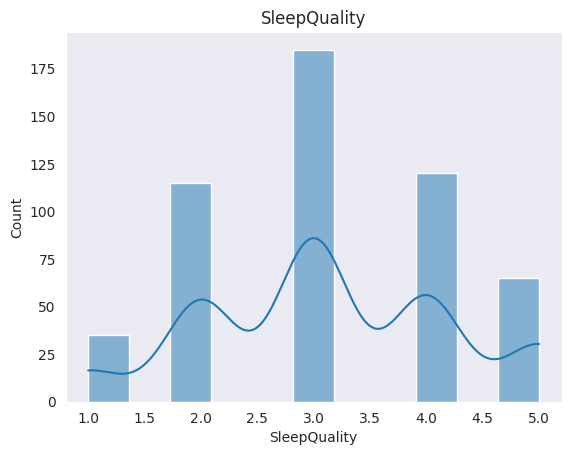

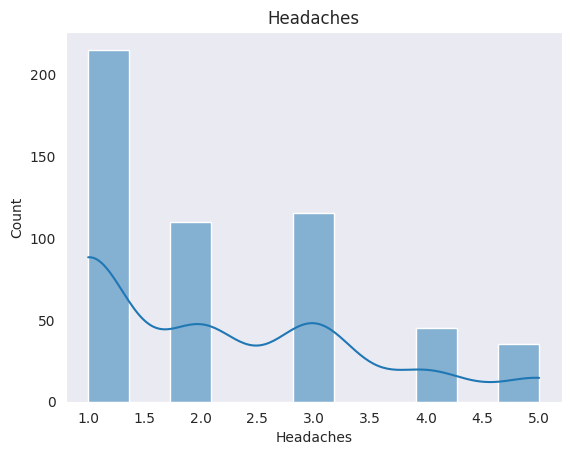

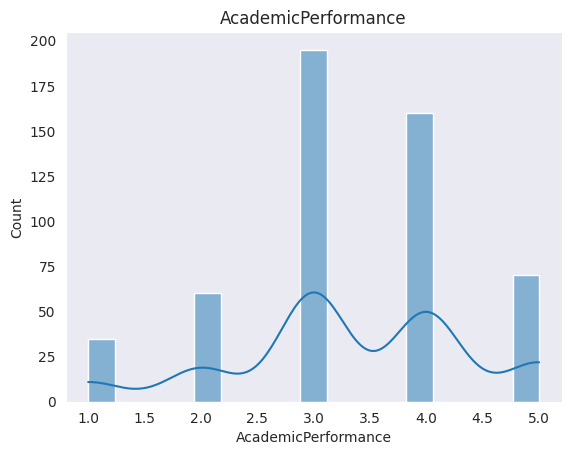

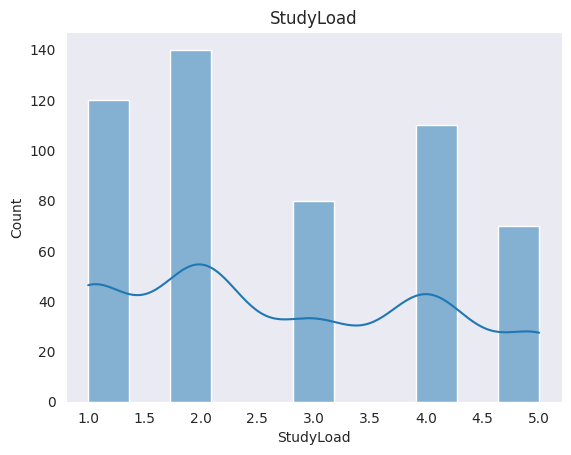

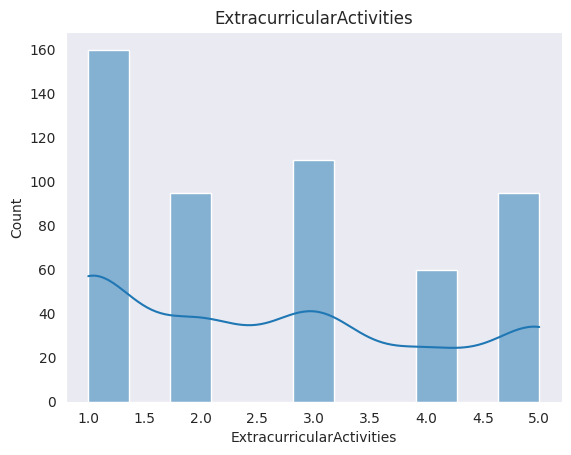

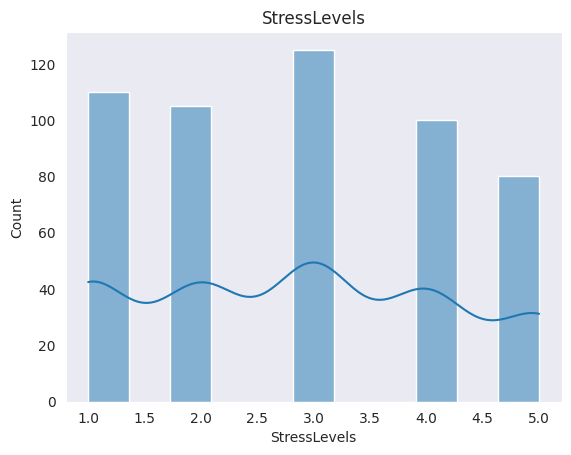

In [16]:
for column in data.columns:
    sns.histplot(data=data, x=column, kde=True)
    plt.title(column)
    plt.show()

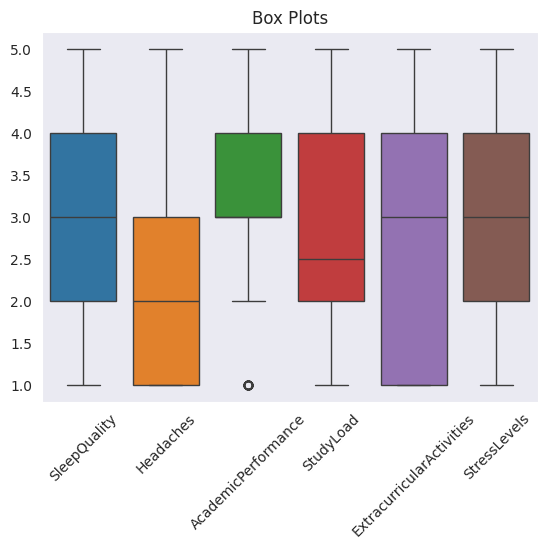

In [21]:
sns.boxplot(data=data)
plt.title("Box Plots")
plt.xticks(rotation=45)
plt.show()

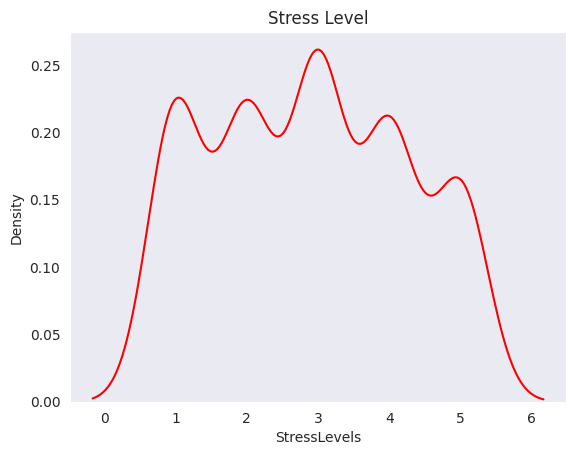

In [39]:
sns.kdeplot(data["StressLevels"],color="red")
plt.title("Stress Level")
plt.show()

## Bivariate Analysis

Regression Plots

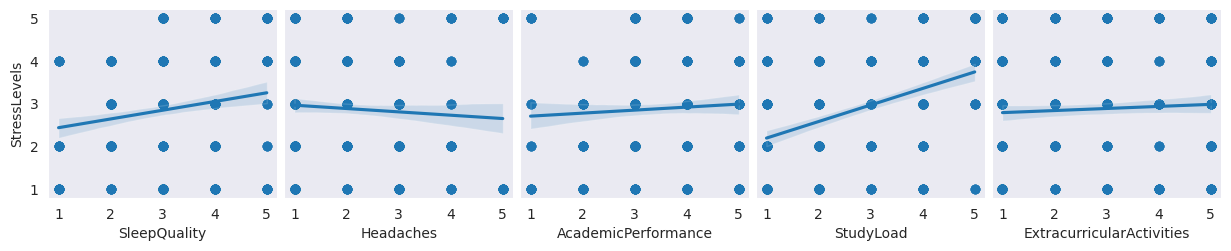

In [25]:
sns.pairplot(data=data, x_vars=data.columns[:-1], y_vars='StressLevels', kind='reg')
plt.show()

Stress is directly proportional to study load and sleep quality

KDE pair plot

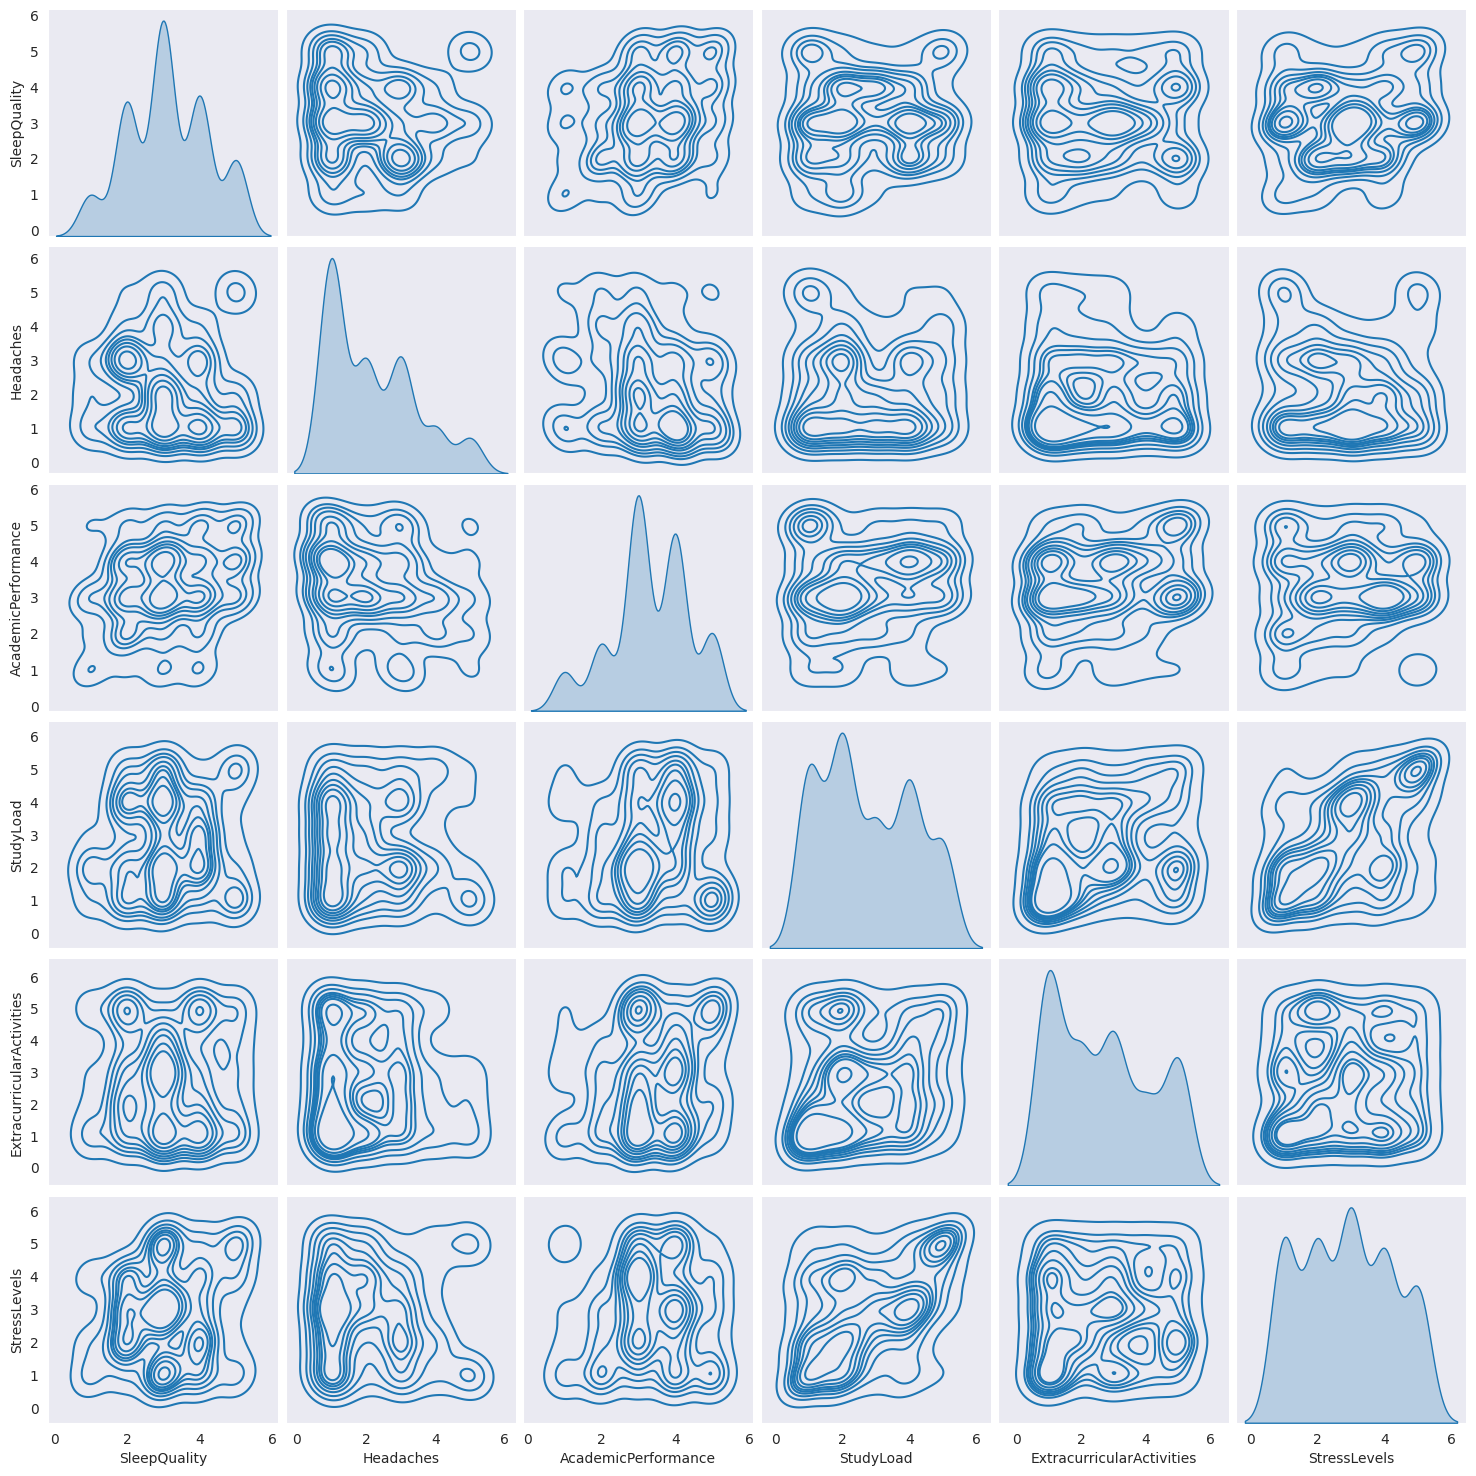

In [30]:
sns.pairplot(data=data, kind="kde")
plt.show()

Correlation Heatmap

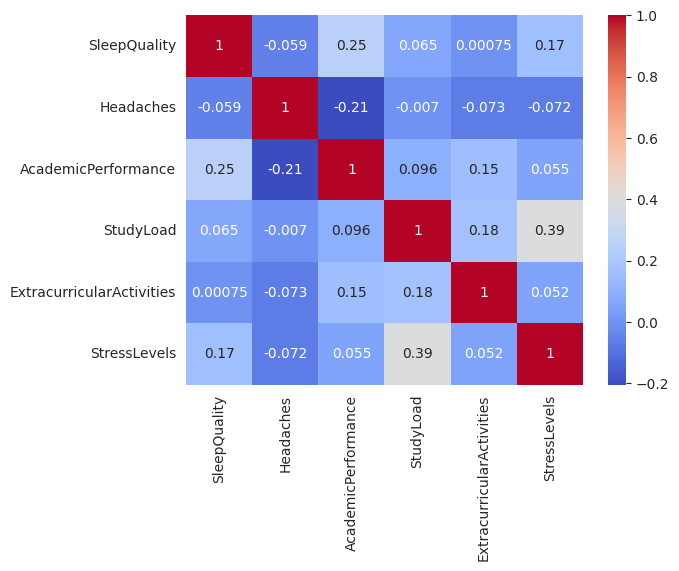

In [26]:
corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

Stress levels are negetives correlated to headaches.

## Model Selection

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error

In [42]:
X = data[['SleepQuality', 'Headaches', 'AcademicPerformance', 'StudyLoad', 'ExtracurricularActivities']]
y = data['StressLevels']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [40]:
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR(),
    'XGBoost Regressor': xgb.XGBRegressor(random_state=42)
}

In [44]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name}: R^2 score: {r2:.2f}, MAE: {mae:.2f}")

Linear Regression: R^2 score: 0.23, MAE: 1.01
Decision Tree: R^2 score: 0.91, MAE: 0.13
Random Forest: R^2 score: 0.90, MAE: 0.18
Gradient Boosting: R^2 score: 0.74, MAE: 0.55
Support Vector Regressor: R^2 score: 0.60, MAE: 0.60
XGBoost Regressor: R^2 score: 0.91, MAE: 0.13


- Both Decision Tree and XGBoost have similar performance in terms of R^2 score and MAE.
- **Decision Tree Regressor**: Easier to interpret as you can visualize the tree and understand the decision-making process.

So I am selecting DTR.

Lets use Grid Search CV for getting best hyper parameters of model.

In [67]:
from sklearn.model_selection import GridSearchCV

In [86]:
dt = DecisionTreeRegressor(random_state=42)
param_dist = {
  'criterion':['squared_error','friedman_mse','absolute_error','poisson'],
  'splitter':['best','random'],
  'max_depth':[5,7,10],
  'max_features':[None, 'sqrt', 'log2']
}

In [87]:
grid_search = GridSearchCV(dt, param_dist, scoring='r2', n_jobs=-1)

In [88]:
grid_search.fit(X_train, y_train)


GridSearchCV(estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['squared_error', 'friedman_mse',
                                       'absolute_error', 'poisson'],
                         'max_depth': [5, 7, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'splitter': ['best', 'random']},
             scoring='r2')

In [89]:
best_params = grid_search.best_params_
print("Best Parameters: ", best_params)

Best Parameters:  {'criterion': 'squared_error', 'max_depth': 10, 'max_features': None, 'splitter': 'best'}


In [90]:
best_dt = DecisionTreeRegressor(**best_params, random_state=42)
best_dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=42)

In [91]:
y_pred = best_dt.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Final Model - R^2 score: {r2:.2f}, MAE: {mae:.2f}")

Final Model - R^2 score: 0.88, MAE: 0.20


Lets save this model

In [92]:
import joblib

joblib.dump(best_dt, "model.pkl")

['model.pkl']